# Automated Region Seeding Using Visibility  

In [1]:
%load_ext autoreload

In [1]:
import numpy as np
from functools import partial
import visualizations_utils as viz_utils
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display

In [8]:
#pydrake imports
import pydrake
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.solvers import mathematicalprogram as mp
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint, Role

import pydrake.multibody.rational_forward_kinematics as rational_forward_kinematics
from pydrake.multibody.tree import JacobianWrtVariable
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import (IrisOptionsRationalSpace, 
                                           IrisInRationalConfigurationSpace, 
                                           HPolyhedron, 
                                           Hyperellipsoid,
                                           Iris, IrisOptions)
from pydrake.common import FindResourceOrThrow
#from pydrake.all import ConnectMeshcatVisualizer
from pydrake.all import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role, StartMeshcat,InverseKinematics, RotationMatrix
from meshcat import Visualizer
from visprm import VPRMSeeding, RandSeeding
from dijkstraspp import DijkstraSPPsolver
from pydrake.all import Rgba, Sphere

In [66]:
meshcat1 = StartMeshcat()
meshcat1.Delete()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [67]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
parser = Parser(plant)
visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat1)
directives_file = FindResourceOrThrow("drake/C_Iris_Examples/7_dof_directives.yaml") 
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()
diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)
Ratfk = RationalForwardKinematics(plant)

<ipython-input-67-10f4518a046a>:4: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat1)


In [11]:

# #model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/urdf/iiwa14_polytope_collision.urdf")
# model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
# shunk = FindResourceOrThrow("drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf")
# #model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
# #model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")

# #box_file = FindResourceOrThrow("drake/sandbox/assets/box.urdf")
# box_file_1 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves1.sdf")
# box_file_2 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves2.sdf")
# box_file_3 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves3.sdf")
# box_file_4 = FindResourceOrThrow("drake/C_Iris_Examples/assets/shelves4.sdf")
# lid_file = FindResourceOrThrow("drake/C_Iris_Examples/assets/lid.urdf")
# ground_file = FindResourceOrThrow("drake/C_Iris_Examples/assets/ground.urdf")

# models =[]

# builder = DiagramBuilder()


# plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat1)
# models.append(Parser(plant, scene_graph).AddModelFromFile(model_file))

# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_1))
# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_2))
# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_3))
# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_4))
# models.append(Parser(plant, scene_graph).AddModelFromFile(lid_file))
# models.append(Parser(plant, scene_graph).AddModelFromFile(ground_file))

# sp = 0.4
# x_fac = 1.2
# locs = [ [0,0,0], 
#         [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
#         [0.0 ,0 , 0.95], [0.0 ,0 , -0.05]] 
# idx = 0
# for model in models:
#     plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), RigidTransform(locs[idx]))
#     idx +=1
    
# #weld shunk
# tf_shunk = RigidTransform(RotationMatrix(pydrake.math.RollPitchYaw(np.array([np.pi/2, 0, 0]))), np.array([0, 0, 0.114]))
# endeff = plant.get_body(plant.GetBodyIndices(models[0])[7]).body_frame()
# shunkframe = plant.get_body(plant.GetBodyIndices(models[-1])[0]).body_frame()
# plant.WeldFrames(shunkframe, endeff, tf_shunk)
    
# plant.Finalize()
# #visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, )

# diagram = builder.Build()
# context = diagram.CreateDefaultContext()
# plant_context = plant.GetMyContextFromRoot(context)
# diagram.Publish(context)


In [12]:
sliders = []
for joint_idx in range(1,8):
    sliders.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
col_shunk_col =  Rgba(0.8, 0.0, 0, 1)    
col_shunk_free =  Rgba(0.0, 0.8, 0.5, 1)    

def showres(q):
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q[joint_idx-1])
    col = col_func_handle(q)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        meshcat1.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        meshcat1.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    meshcat1.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    diagram.Publish(context)
    print("              ", end = "\r")
    print(col , end = "\r")

    
def set_joint_angles(vals):
    for idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{idx}").set_angle(plant_context, vals[idx-1])
    
    
    
q_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# q_start = [-1.37, -1.39, -1.57, -1.19, -1.57, 0.00, 0.00]
# q_end = [1.53, -1.19, 1.83, 0.91, -1.27, -0.59, 0.00]
q = q_init.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

In [13]:


def plot_points(points, 
                size = 0.02, 
                color = Rgba(0.06, 0.0, 0, 1), 
                start_idx = 0, 
                prefix = 'point'):
       
        
        for i in range(points.shape[0]):
            pt = points[i]
            set_joint_angles(pt)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            
            meshcat1.SetObject(f"/iris/points/{prefix}/{i+start_idx}",
                                   Sphere(size),
                                   color)
            
            meshcat1.SetTransform(f"/iris/points/{prefix}/{i+start_idx}",
                                       RigidTransform(RotationMatrix(),
                                                      tf))

In [14]:
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_4', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_5', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_6', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_7', max=3.05433, min=-3.05433)

In [30]:
#problem config
 

start = np.array([1.13294, 1.3056, 0.03294, -1.2944, -1.76706, 1.5056, 0.0])
target = np.array([-1.86706, 0.5056, -0.26706, -1.0944, -1.36706, 1.1056, 0.04567])

poi = np.array([[1.13294, 1.3056, 0.03294, -1.2944, -1.76706, 1.5056, 0.0],
                [-1.96706,  1.3056 ,  0.03294, -1.2944 , -1.76706,  1.5056 ,
        0.     ],
                [-1.86706, 0.5056, -0.26706, -1.0944, -1.36706, 1.1056, 0.04567],
         [-1.26706,  0.9056 ,  0.13294, -1.0944 , -1.66706, -1.1944 ,
        0.04567],
         [-1.26706,  1.3056 ,  0.13294, -1.0944 , -1.46706, -1.1944 ,
        0.04567],
         [-1.26706,  1.2056 , -0.16706,  0.1056 , -1.46706, -1.1944 ,
        0.04567],
         [ 1.13294,  0.8056 ,  0.03294, -1.2944 , -1.76706,  1.5056 ,
        0.     ],
        [ 1.03294,  0.1056 , -0.06706, -1.5944 , -1.46706,  1.0056 ,
       -1.55433],
        [-1.76706,  0.9056 , -0.26706, -1.0944 , -1.36706,  1.1056 ,
        1.94567],
        [ 2.03294,  0.9056 , -0.26706, -1.0944 , -1.16706, -1.2944 ,
        -0.45433],
        [ 2.23294,  0.6056 , -0.26706, -1.0944 , -1.46706, -1.2944 ,
        -0.05433],
        [ 1.83294,  1.9056 , -0.16706,  0.2056 , -1.36706, -1.2944 ,
        2.71],])
       
def pull_back_point(pt):
    set_joint_angles(pt)
    shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    shunk_frame = shunk.body_frame()
    world_frame = plant.world_frame() 
    J = plant.CalcJacobianSpatialVelocity(plant_context, 
                                          JacobianWrtVariable.kQDot,
                                            shunk_frame,
                                            [0,0,0],
                                            world_frame,
                                         world_frame)


    #shunk = plant.get_body(pydrake.multibody.tree.BodyIndex(9))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()

    # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    v_pullback = -tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    pos_pullback = tf + v_pullback
    pt_new = pt + np.linalg.pinv(J[3:,:])@v_pullback
    return pt_new

helpers = []
for p in poi:
    ph = pull_back_point(p)
    helpers.append(ph)
helpers = np.array(helpers)
poi = np.concatenate((poi, helpers), axis = 0)

showres(target)
limits_q =[plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]
crit_idx = [-1, 0, 2, 4]
for idx in crit_idx:
    limits_q[0][idx] *=0.90
    limits_q[1][idx] *=0.90

limits_t = [Ratfk.ComputeTValue(l, np.zeros(len(l))) for l in limits_q]
domain = HPolyhedron.MakeBox(limits_t[0], limits_t[1])
#poi = [start, target]
plot_points(np.array(poi))
for p in poi:
    print(domain.PointInSet(Ratfk.ComputeTValue(p, np.zeros(7))))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [17]:
pt = poi[0]
showres(pt)
q = pt

# Setup SNOPT IRIS

In [18]:

snopt_iris_options = IrisOptionsRationalSpace()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 15
snopt_iris_options.configuration_space_margin = 2e-3
snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
snopt_iris_options.q_star = np.zeros(7)
snopt_iris_options.relative_termination_threshold = 0.1



def SNOPT_IRIS(q_seed,  regions, plant, context, snoptiris_options, default_domain):
    #print('snopt iris call')
    snoptiris_options.configuration_obstacles = []
    if regions is not None:
        obstacles = []
        for r in regions:
            offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
            rnew = HPolyhedron(r.A(), r.b()-offset)
            obstacles.append(rnew)
        snopt_iris_options.configuration_obstacles = obstacles
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), q_seed.reshape(-1,1))
    t_seed = Ratfk.ComputeTValue(q_seed, np.zeros(7))
    r = IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context), snoptiris_options, domain)
    return r

SNOPT_IRIS_Handle = partial(SNOPT_IRIS,
                            plant = plant,
                            context = context,
                            snoptiris_options = snopt_iris_options,
                            default_domain = domain)

# Construct vis checker (here still sample based)

In [19]:
def vis(t1, t2, num_checks, visualizer):
    t1flat = t1.reshape(-1)
    t2flat = t2.reshape(-1)
    if np.linalg.norm(t1-t2) < 1e-6:
        return [(1-col_func_handle(Ratfk.ComputeQValue(t1flat, np.zeros(7))))>0,
                None]
    tvec = np.linspace(0,1, num_checks)
    for t in tvec:
        tinterp = t1flat*t + (1-t)*t2flat
        if col_func_handle(Ratfk.ComputeQValue(tinterp, np.zeros(7))):
            return [False, None]
    else:
        return [True, None]
is_LOS = partial(vis, num_checks = 40, visualizer = visualizer)

# Run Seeding Setup and Guard Phase

In [20]:
LOAD_CHECKPOINT = False
np.random.seed(12)
vs = VPRMSeeding(poi,
                 alpha = 0.05,
                 limits = limits_q,
                 collision_handle = col_func_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                 iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                 point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
if not LOAD_CHECKPOINT:
    vs.set_guard_regions()
else:
    import pickle
    path = 'seedingcheckpoints/7DOF_VPRMSeeding_state7.pickle'
    with open(path, 'rb') as f:
        checkpoint = pickle.load(f)
    vs.load_checkpoint(checkpoint)

[16:07:32] [VPRMSeeding] Expecting points of interest in q
[16:07:32] [VPRMSeeding] GuardInsertion attempts M: 58
[16:07:32] [VPRMSeeding] 0.95 probability that unseen region is less than 5.0 "%" of Cfree 


In [21]:
if not LOAD_CHECKPOINT:
    vs.guard_phase()
    vs.refine_guards()
    seed_points = vs.seed_points
    regions_A = [r.A() for r in vs.regions]
    regions_b = [r.b() for r in vs.regions]
    sample_set_points = [s[0] for s in vs.samples_outside_regions.values()]
    sample_set_vis_regions = [[vs.regions.index(rs) for rs in s[1]] for s in vs.samples_outside_regions.values()]

    data_checkpoint = {'seedpoints': seed_points, 
                       'regionsA': regions_A,
                       'regionsB': regions_b,
                       'sample_set_points': sample_set_points,
                       'sample_set_vis_regions':sample_set_vis_regions}

    import pickle
    with open("7DOF_VPRMSeeding_state7.pickle", "wb") as f:
        pickle.dump(data_checkpoint,f)
else: 
    print('done')

[16:10:20] [VPRMSeeding] New guard placed N =  24 it =  0
[16:10:36] [VPRMSeeding] Sample set size 0
[16:10:36] [VPRMSeeding] New guard placed N =  25 it =  1
[16:10:48] [VPRMSeeding] Sample set size 0
[16:10:48] [VPRMSeeding] New guard placed N =  26 it =  2
[16:11:14] [VPRMSeeding] Sample set size 1
[16:11:14] [VPRMSeeding] New guard placed N =  27 it =  3
[16:11:22] [VPRMSeeding] Sample set size 3
[16:11:22] [VPRMSeeding] New guard placed N =  28 it =  1
[16:11:49] [VPRMSeeding] Sample set size 3
[16:11:49] [VPRMSeeding] New guard placed N =  29 it =  1
[16:12:13] [VPRMSeeding] Sample set size 3
[16:12:13] [VPRMSeeding] New guard placed N =  30 it =  1
[16:12:31] [VPRMSeeding] Sample set size 3
[16:12:31] [VPRMSeeding] New guard placed N =  31 it =  1
[16:12:52] [VPRMSeeding] Sample set size 3
[16:12:52] [VPRMSeeding] New guard placed N =  32 it =  1
[16:13:04] [VPRMSeeding] Sample set size 3
[16:13:04] [VPRMSeeding] New guard placed N =  33 it =  1
[16:13:25] [VPRMSeeding] Sample s

[16:23:58] [VPRMSeeding] New guard placed N =  104 it =  3
[16:24:03] [VPRMSeeding] Sample set size 351
[16:24:04] [VPRMSeeding] New guard placed N =  105 it =  9
[16:24:10] [VPRMSeeding] Sample set size 359
[16:24:10] [VPRMSeeding] New guard placed N =  106 it =  6
[16:24:11] [VPRMSeeding] Sample set size 364
[16:24:11] [VPRMSeeding] New guard placed N =  107 it =  2
[16:24:16] [VPRMSeeding] Sample set size 365
[16:24:16] [VPRMSeeding] New guard placed N =  108 it =  5
[16:24:17] [VPRMSeeding] Sample set size 369
[16:24:17] [VPRMSeeding] New guard placed N =  109 it =  5
[16:24:24] [VPRMSeeding] Sample set size 373
[16:24:27] [VPRMSeeding] New guard placed N =  110 it =  35
[16:24:34] [VPRMSeeding] Sample set size 407
[16:24:35] [VPRMSeeding] New guard placed N =  111 it =  14
[16:24:47] [VPRMSeeding] Sample set size 420
[16:24:48] [VPRMSeeding] New guard placed N =  112 it =  13
[16:24:53] [VPRMSeeding] Sample set size 432
[16:24:53] [VPRMSeeding] New guard placed N =  113 it =  5
[1

In [103]:
b = [vs.compute_kernel_of_guard(a) for a in vs.guard_regions]

In [144]:
def point_in_regions(pt, regions): 
    for r in regions:
        if r.PointInSet(pt):
            return True
    return False 

pir = partial(point_in_regions, regions = vs.regions)

def get_cover_est(N = 10000):
    ntot = 0
    for idx in range(N):
        pt= vs.sample_node_pos(outside_regions=False)
        if pir(pt):
            ntot +=1
    return ntot*1.0/N

In [145]:
get_cover_est()

0.0135

In [125]:
#vs.fill_remaining_space_phase()

[18:55:00] [VPRMSeeding] New Region placed N =  112 , it =  1
[18:55:19] [VPRMSeeding] New Region placed N =  113 , it =  0
[18:55:48] [VPRMSeeding] New Region placed N =  114 , it =  0
[18:56:19] [VPRMSeeding] New Region placed N =  115 , it =  0
[18:56:59] [VPRMSeeding] New Region placed N =  116 , it =  0
[18:57:27] [VPRMSeeding] New Region placed N =  117 , it =  1
[18:57:51] [VPRMSeeding] New Region placed N =  118 , it =  0
[18:58:23] [VPRMSeeding] New Region placed N =  119 , it =  0
[18:58:56] [VPRMSeeding] New Region placed N =  120 , it =  0
[18:59:27] [VPRMSeeding] New Region placed N =  121 , it =  0
[18:59:41] [VPRMSeeding] New Region placed N =  122 , it =  0
[19:00:45] [VPRMSeeding] New Region placed N =  123 , it =  0
[19:00:58] [VPRMSeeding] New Region placed N =  124 , it =  1
[19:01:23] [VPRMSeeding] New Region placed N =  125 , it =  1
[19:01:48] [VPRMSeeding] New Region placed N =  126 , it =  0
[19:02:12] [VPRMSeeding] New Region placed N =  127 , it =  0
[19:02:3

[20:04:23] [VPRMSeeding] New Region placed N =  239 , it =  1
[20:04:51] [VPRMSeeding] New Region placed N =  240 , it =  0
[20:05:29] [VPRMSeeding] New Region placed N =  241 , it =  2
[20:06:26] [VPRMSeeding] New Region placed N =  242 , it =  0
[20:06:51] [VPRMSeeding] New Region placed N =  243 , it =  0
[20:07:49] [VPRMSeeding] New Region placed N =  244 , it =  0
[20:08:55] [VPRMSeeding] New Region placed N =  245 , it =  0
[20:09:53] [VPRMSeeding] Mosek failed, deleting point
[20:09:53] [VPRMSeeding] New Region placed N =  245 , it =  0
[20:11:15] [VPRMSeeding] Mosek failed, deleting point
[20:11:15] [VPRMSeeding] New Region placed N =  245 , it =  0
[20:11:21] [VPRMSeeding] Mosek failed, deleting point
[20:11:21] [VPRMSeeding] New Region placed N =  245 , it =  0
[20:11:21] [VPRMSeeding] Mosek failed, deleting point
[20:11:21] [VPRMSeeding] New Region placed N =  245 , it =  0
[20:11:21] [VPRMSeeding] Mosek failed, deleting point
[20:11:21] [VPRMSeeding] New Region placed N =  

[20:11:45] [VPRMSeeding] Mosek failed, deleting point
[20:11:45] [VPRMSeeding] New Region placed N =  245 , it =  16
[20:11:45] [VPRMSeeding] Mosek failed, deleting point
[20:11:45] [VPRMSeeding] New Region placed N =  245 , it =  16
[20:11:45] [VPRMSeeding] Mosek failed, deleting point
[20:11:45] [VPRMSeeding] New Region placed N =  245 , it =  17
[20:11:45] [VPRMSeeding] Mosek failed, deleting point
[20:11:45] [VPRMSeeding] New Region placed N =  245 , it =  17
[20:11:46] [VPRMSeeding] Mosek failed, deleting point
[20:11:46] [VPRMSeeding] New Region placed N =  245 , it =  17
[20:11:46] [VPRMSeeding] Mosek failed, deleting point
[20:11:46] [VPRMSeeding] New Region placed N =  245 , it =  17
[20:11:46] [VPRMSeeding] Mosek failed, deleting point
[20:11:46] [VPRMSeeding] New Region placed N =  245 , it =  17
[20:11:46] [VPRMSeeding] Mosek failed, deleting point
[20:11:46] [VPRMSeeding] New Region placed N =  245 , it =  17
[20:11:46] [VPRMSeeding] Mosek failed, deleting point
[20:11:46]

[20:12:00] [VPRMSeeding] Mosek failed, deleting point
[20:12:00] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:00] [VPRMSeeding] Mosek failed, deleting point
[20:12:00] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:00] [VPRMSeeding] Mosek failed, deleting point
[20:12:00] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:00] [VPRMSeeding] Mosek failed, deleting point
[20:12:00] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:00] [VPRMSeeding] Mosek failed, deleting point
[20:12:00] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:01] [VPRMSeeding] Mosek failed, deleting point
[20:12:01] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:01] [VPRMSeeding] Mosek failed, deleting point
[20:12:01] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:01] [VPRMSeeding] Mosek failed, deleting point
[20:12:01] [VPRMSeeding] New Region placed N =  245 , it =  28
[20:12:01] [VPRMSeeding] Mosek failed, deleting point
[20:12:01]

[20:12:15] [VPRMSeeding] Mosek failed, deleting point
[20:12:15] [VPRMSeeding] New Region placed N =  245 , it =  45
[20:12:15] [VPRMSeeding] Mosek failed, deleting point
[20:12:15] [VPRMSeeding] New Region placed N =  245 , it =  45
[20:12:15] [VPRMSeeding] Mosek failed, deleting point
[20:12:16] [VPRMSeeding] New Region placed N =  245 , it =  46
[20:12:16] [VPRMSeeding] Mosek failed, deleting point
[20:12:16] [VPRMSeeding] New Region placed N =  245 , it =  47
[20:12:16] [VPRMSeeding] Mosek failed, deleting point
[20:12:16] [VPRMSeeding] New Region placed N =  245 , it =  48
[20:12:16] [VPRMSeeding] Mosek failed, deleting point
[20:12:16] [VPRMSeeding] New Region placed N =  245 , it =  48
[20:12:16] [VPRMSeeding] Mosek failed, deleting point
[20:12:16] [VPRMSeeding] New Region placed N =  245 , it =  48
[20:12:16] [VPRMSeeding] Mosek failed, deleting point
[20:12:16] [VPRMSeeding] New Region placed N =  245 , it =  48
[20:12:17] [VPRMSeeding] Mosek failed, deleting point
[20:12:17]

True

In [143]:
#np.mean([a.A().shape[0]for a in vs.regions])

124.31020408163265

# Plot Results after Guard Phase

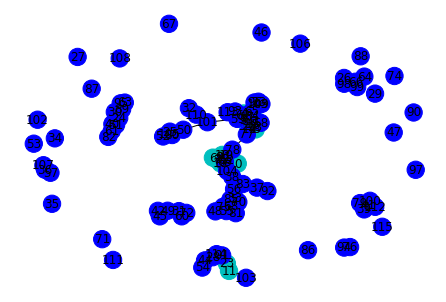

In [22]:
vs.draw_connectivity_graph()
sampleset = [v[0] for v in vs.samples_outside_regions.values()]
plot_points(np.array(vs.seed_points), prefix = 'guard', color = Rgba(0.06, 0.0, 0.8, 1))
plot_points(np.array(sampleset), size=0.01, prefix = 'sampleset', color = Rgba(0.06, 0.8, 0.8, 1))

# Connectivity Phase

In [23]:
vs.connectivity_phase() 

[16:27:16] [VPRMSeeding] Num connected Components Vis: 6
[16:27:54] [VPRMSeeding] New region added [ 1.1919349  -2.00040104 -0.46439786 -0.71680219  0.45410612  0.69760319
  0.12497188]
[16:27:54] [VPRMSeeding] Sample set size 503 num keys to del  2
[16:27:55] [VPRMSeeding] Num connected Components Vis: 5
[16:28:36] [VPRMSeeding] New region added [ 1.46821728 -1.72214101  0.02556264 -0.26787573  1.12944453  0.29856002
 -0.28047243]
[16:28:36] [VPRMSeeding] Sample set size 500 num keys to del  3
[16:28:36] [VPRMSeeding] Num connected Components Vis: 4
[16:29:13] [VPRMSeeding] New region added [ 1.04227987  0.71035848 -2.5035436  -1.88081817  0.03021535  1.71326287
  2.71840218]
[16:29:13] [VPRMSeeding] Sample set size 499 num keys to del  1
[16:29:14] [VPRMSeeding] Num connected Components Vis: 4
[16:30:10] [VPRMSeeding] New region added [ 1.73124841 -1.51898603 -1.38717024  0.03847282  1.94423769  0.98457611
  2.30531462]
[16:30:10] [VPRMSeeding] Sample set size 498 num keys to del  1


True

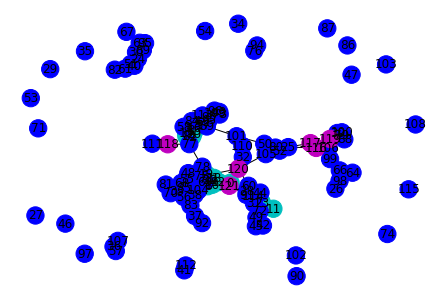

In [24]:
vs.draw_connectivity_graph()

# Build Configuartion Graph for SPP

In [25]:
dspp = DijkstraSPPsolver(vs.regions, partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7)))

## Helper functions for animations

In [26]:
def densify_waypoints(waypoints_t):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_t[:-1])):
        a = waypoints_t[idx]
        b = waypoints_t[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            ta = a*tval + b*(1-tval)
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            set_joint_angles(qa)
            tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_t[idx]*tval + waypoints_t[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, ta in enumerate(dense_waypoints):
        qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        set_joint_angles(qa)
        tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        meshcat1.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        meshcat1.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

# Prebuild Adjacency Matrix 

In [111]:
# base_ad_mat, node_intersections = build_base_adjacency_matrix(vs.regions)
# point_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))

In [ ]:
import time
start = poi[np.random.choice(12,1)[0]]
meshcat1.Delete("/iris/points/traj/") 
terminate = False
for _ in range(90):
    #vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(12,1)[0]]
        if nxt[0] != start[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path = False)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion)
    #print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for ta in dense_waypoints:
            qa = Ratfk.ComputeQValue(ta, np.zeros(7))
            showres(qa)
            if col_func_handle(qa):
                terminate = True
                color = Rgba(1,0,0.1,0.4)
   
                tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
                tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

                meshcat1.SetObject(f"/iris/points/traj/coll",
                               Sphere(0.1),
                               color)

                meshcat1.SetTransform(f"/iris/points/traj/coll",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
                
                
                #break
            time.sleep(0.012)
        #if terminate:
        #    break
        start = nxt
        #time.sleep(0.1)
        meshcat1.Delete("/iris/points/traj/")     
    else:
        nxt = vs.sample_in_regions()

In [117]:
len(vs.regions)

228

In [120]:
get_cover_est()

0.0166

# Evaluation

In [97]:
from datetime import date, datetime
import time
from visprm import RandSeeding
now = datetime.now()
timestamp = now.strftime("%y_%m_%d_%H_%M_%S")
filename = timestamp+'eval_log.log'
with open(filename, 'w+') as file:  
    for i in range(20):
        t1 = time.time()
        np.random.seed(i)
        vs2 = VPRMSeeding(poi,
                     alpha = 0.1,
                     limits = limits_q,
                     collision_handle = col_func_handle,
                     is_in_line_of_sight = is_LOS, 
                     iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
                     iris_handle_with_obstacles = SNOPT_IRIS_Handle,
                     point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                     )
        vs2.set_guard_regions()
        vs2.guard_phase()
        success = vs2.connectivity_phase()
        t2 = time.time()
        number_guards = len(vs2.guard_regions)
        number_regions = len(vs2.regions)
        number_samples = len(vs2.samples_outside_regions)
        #determine coverage
        samps_cnt = 10000
        samp_in_regions = 0
        for _ in range(samps_cnt):
            q_samp = vs2.sample_node_pos(outside_regions=False)
            if vs2.point_in_regions(q_samp):
                samp_in_regions += 1
        coverage = samp_in_regions/samps_cnt
        run_string = [(f"""{'--visprm seed:'}{i},\n"""),
                     (f"""{'success: '+str(success)},\n"""),
                     (f"""{'nr: '}{number_regions},\n"""),
                     (f"""{'ng: '}{number_guards},\n"""),
                     (f"""{'ns: '}{number_samples},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                     ]
        file.writelines(run_string)
        print('switch to random seeding')
        t1 = time.time()
        np.random.seed(i)
        rs2 = RandSeeding(poi,
              alpha = 0.1,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
        rs2.set_init_regions()
        success = rs2.sample_regions_phase()
        t2 = time.time()
        number_regions = len(rs2.regions)
        #number_samples = len(rs.samples_outside_regions)
        #determine coverage
        samps_cnt = 10000
        samp_in_regions = 0
        for _ in range(samps_cnt):
            q_samp = rs2.sample_node_pos()
            if rs2.point_in_regions(q_samp):
                samp_in_regions += 1
        coverage = samp_in_regions/samps_cnt
        run_string = [(f"""{'--rand seed:'}{i},\n"""),
                     (f"""{'success: '+str(success)},\n"""),
                     (f"""{'nr: '}{number_regions},\n"""),
                     (f"""{'coverage: '}{coverage:.4f},\n"""),
                     (f"""{'runtime: '}{t2-t1:.4f},\n"""),
                      
                     ]
        file.writelines(run_string)

[02:48:44] [VPRMSeeding] Expecting points of interest in q
[02:48:44] [VPRMSeeding] GuardInsertion attempts M: 44
[02:48:44] [VPRMSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 
[02:49:13] [VPRMSeeding] New guard placed N =  12 it =  0
[02:49:25] [VPRMSeeding] Sample set size 0
[02:49:25] [VPRMSeeding] New guard placed N =  13 it =  2
[02:49:36] [VPRMSeeding] Sample set size 1
[02:49:36] [VPRMSeeding] New guard placed N =  14 it =  1
[02:49:51] [VPRMSeeding] Sample set size 1
[02:49:51] [VPRMSeeding] New guard placed N =  15 it =  4
[02:50:04] [VPRMSeeding] Sample set size 4
[02:50:04] [VPRMSeeding] New guard placed N =  16 it =  3
[02:50:05] [VPRMSeeding] Sample set size 6
[02:50:05] [VPRMSeeding] New guard placed N =  17 it =  1
[02:50:13] [VPRMSeeding] Sample set size 6
[02:50:13] [VPRMSeeding] New guard placed N =  18 it =  4
[02:50:14] [VPRMSeeding] Sample set size 9
[02:50:14] [VPRMSeeding] New guard placed N =  19 it =  2
[02:50:26] [VPRMSeeding] Sampl

[02:59:48] [RandSeeding] New Region placed N =  21 , it =  0
[02:59:58] [RandSeeding] New Region placed N =  22 , it =  1
[03:00:15] [RandSeeding] New Region placed N =  23 , it =  0
[03:00:24] [RandSeeding] New Region placed N =  24 , it =  0
[03:00:27] [RandSeeding] New Region placed N =  25 , it =  0
[03:00:41] [RandSeeding] New Region placed N =  26 , it =  0
[03:00:48] [RandSeeding] New Region placed N =  27 , it =  0
[03:00:58] [RandSeeding] New Region placed N =  28 , it =  0
[03:01:13] [RandSeeding] New Region placed N =  29 , it =  0
[03:01:19] [RandSeeding] New Region placed N =  30 , it =  0
[03:01:24] [RandSeeding] New Region placed N =  31 , it =  0
[03:01:40] [RandSeeding] New Region placed N =  32 , it =  0
[03:01:47] [RandSeeding] New Region placed N =  33 , it =  0
[03:01:52] [RandSeeding] New Region placed N =  34 , it =  0
[03:02:05] [RandSeeding] New Region placed N =  35 , it =  0
[03:02:09] [RandSeeding] New Region placed N =  36 , it =  1
[03:02:14] [RandSeeding]

[03:18:17] [VPRMSeeding] Num connected Components Vis: 3
[03:18:36] [VPRMSeeding] New region added [-1.96042101  1.8583186  -1.24530319  1.03756065 -0.51779059  1.34025575
  1.61310962]
[03:18:36] [VPRMSeeding] Sample set size 180 num keys to del  4
[03:18:36] [VPRMSeeding] Num connected Components Vis: 3
[03:18:55] [VPRMSeeding] New region added [ 0.83083831  0.71198136 -0.12108799  2.02183896  1.02368161  1.13444009
 -1.98758927]
[03:18:55] [VPRMSeeding] Sample set size 179 num keys to del  1
[03:18:56] [VPRMSeeding] Num connected Components Vis: 3
[03:19:04] [VPRMSeeding] New region added [-1.71384084 -0.79312604  2.80250894 -1.76901695 -1.3681769  -0.85231111
 -0.48156143]
[03:19:04] [VPRMSeeding] Sample set size 178 num keys to del  1
[03:19:05] [VPRMSeeding] Num connected Components Vis: 3
[03:19:20] [VPRMSeeding] New region added [-0.46070266  0.13907433  2.72029595 -1.83695496  2.28268233 -1.25057138
  2.8685291 ]
[03:19:20] [VPRMSeeding] Sample set size 177 num keys to del  1


[03:35:02] [VPRMSeeding] New guard placed N =  46 it =  9
[03:35:03] [VPRMSeeding] Sample set size 94
[03:35:04] [VPRMSeeding] New guard placed N =  47 it =  10
[03:35:05] [VPRMSeeding] Sample set size 103
[03:35:05] [VPRMSeeding] New guard placed N =  48 it =  6
[03:35:06] [VPRMSeeding] Sample set size 108
[03:35:07] [VPRMSeeding] New guard placed N =  49 it =  9
[03:35:19] [VPRMSeeding] Sample set size 116
[03:35:19] [VPRMSeeding] New guard placed N =  50 it =  9
[03:35:22] [VPRMSeeding] Sample set size 124
[03:35:22] [VPRMSeeding] New guard placed N =  51 it =  9
[03:35:25] [VPRMSeeding] Sample set size 132
[03:35:25] [VPRMSeeding] New guard placed N =  52 it =  7
[03:35:29] [VPRMSeeding] Sample set size 138
[03:35:29] [VPRMSeeding] New guard placed N =  53 it =  2
[03:35:33] [VPRMSeeding] Sample set size 139
[03:35:34] [VPRMSeeding] New guard placed N =  54 it =  41
[03:35:40] [VPRMSeeding] Sample set size 179
[03:35:40] [VPRMSeeding] New guard placed N =  55 it =  1
[03:35:44] [VP

[03:56:06] [VPRMSeeding] Sample set size 8
[03:56:07] [VPRMSeeding] New guard placed N =  21 it =  3
[03:56:08] [VPRMSeeding] Sample set size 10
[03:56:08] [VPRMSeeding] New guard placed N =  22 it =  1
[03:56:17] [VPRMSeeding] Sample set size 10
[03:56:17] [VPRMSeeding] New guard placed N =  23 it =  1
[03:56:18] [VPRMSeeding] Sample set size 10
[03:56:18] [VPRMSeeding] New guard placed N =  24 it =  3
[03:56:37] [VPRMSeeding] Sample set size 12
[03:56:37] [VPRMSeeding] New guard placed N =  25 it =  2
[03:56:38] [VPRMSeeding] Sample set size 13
[03:56:38] [VPRMSeeding] New guard placed N =  26 it =  2
[03:56:55] [VPRMSeeding] Sample set size 14
[03:56:55] [VPRMSeeding] New guard placed N =  27 it =  1
[03:57:04] [VPRMSeeding] Sample set size 14
[03:57:04] [VPRMSeeding] New guard placed N =  28 it =  5
[03:57:07] [VPRMSeeding] Sample set size 18
[03:57:07] [VPRMSeeding] New guard placed N =  29 it =  5
[03:57:08] [VPRMSeeding] Sample set size 22
[03:57:08] [VPRMSeeding] New guard plac

[04:12:20] [VPRMSeeding] New guard placed N =  12 it =  0
[04:12:33] [VPRMSeeding] Sample set size 0
[04:12:33] [VPRMSeeding] New guard placed N =  13 it =  3
[04:12:43] [VPRMSeeding] Sample set size 2
[04:12:43] [VPRMSeeding] New guard placed N =  14 it =  2
[04:12:47] [VPRMSeeding] Sample set size 3
[04:12:47] [VPRMSeeding] New guard placed N =  15 it =  1
[04:12:59] [VPRMSeeding] Sample set size 3
[04:12:59] [VPRMSeeding] New guard placed N =  16 it =  2
[04:13:01] [VPRMSeeding] Sample set size 4
[04:13:01] [VPRMSeeding] New guard placed N =  17 it =  1
[04:13:12] [VPRMSeeding] Sample set size 4
[04:13:12] [VPRMSeeding] New guard placed N =  18 it =  1
[04:13:13] [VPRMSeeding] Sample set size 4
[04:13:13] [VPRMSeeding] New guard placed N =  19 it =  1
[04:13:16] [VPRMSeeding] Sample set size 4
[04:13:16] [VPRMSeeding] New guard placed N =  20 it =  4
[04:13:22] [VPRMSeeding] Sample set size 7
[04:13:22] [VPRMSeeding] New guard placed N =  21 it =  5
[04:13:28] [VPRMSeeding] Sample s

[04:22:46] [RandSeeding] New Region placed N =  25 , it =  0
[04:22:57] [RandSeeding] New Region placed N =  26 , it =  0
[04:23:18] [RandSeeding] New Region placed N =  27 , it =  1
[04:23:26] [RandSeeding] New Region placed N =  28 , it =  0
[04:23:33] [RandSeeding] New Region placed N =  29 , it =  1
[04:23:37] [RandSeeding] New Region placed N =  30 , it =  1
[04:23:42] [RandSeeding] New Region placed N =  31 , it =  0
[04:23:58] [RandSeeding] New Region placed N =  32 , it =  0
[04:24:08] [RandSeeding] New Region placed N =  33 , it =  0
[04:24:19] [RandSeeding] New Region placed N =  34 , it =  0
[04:24:37] [RandSeeding] New Region placed N =  35 , it =  0
[04:24:47] [RandSeeding] New Region placed N =  36 , it =  0
[04:25:06] [RandSeeding] New Region placed N =  37 , it =  0
[04:25:14] [RandSeeding] New Region placed N =  38 , it =  0
[04:25:33] [RandSeeding] New Region placed N =  39 , it =  0
[04:26:02] [RandSeeding] New Region placed N =  40 , it =  1
[04:26:16] [RandSeeding]

[04:39:34] [RandSeeding] New Region placed N =  12 , it =  0
[04:39:43] [RandSeeding] New Region placed N =  13 , it =  0
[04:39:57] [RandSeeding] New Region placed N =  14 , it =  0
[04:40:20] [RandSeeding] New Region placed N =  15 , it =  0
[04:40:23] [RandSeeding] New Region placed N =  16 , it =  0
[04:40:39] [RandSeeding] New Region placed N =  17 , it =  0
[04:40:54] [RandSeeding] New Region placed N =  18 , it =  0
[04:41:00] [RandSeeding] New Region placed N =  19 , it =  0
[04:41:04] [RandSeeding] New Region placed N =  20 , it =  0
[04:41:20] [RandSeeding] New Region placed N =  21 , it =  0
[04:41:28] [RandSeeding] New Region placed N =  22 , it =  0
[04:41:38] [RandSeeding] New Region placed N =  23 , it =  0
[04:41:44] [RandSeeding] New Region placed N =  24 , it =  0
[04:41:47] [RandSeeding] New Region placed N =  25 , it =  0
[04:41:52] [RandSeeding] New Region placed N =  26 , it =  0
[04:41:55] [RandSeeding] New Region placed N =  27 , it =  0
[04:42:02] [RandSeeding]

[05:00:58] [VPRMSeeding] Sample set size 139
[05:00:59] [VPRMSeeding] New guard placed N =  48 it =  6
[05:01:06] [VPRMSeeding] Sample set size 144
[05:01:06] [VPRMSeeding] New guard placed N =  49 it =  6
[05:01:07] [VPRMSeeding] Sample set size 149
[05:01:07] [VPRMSeeding] New guard placed N =  50 it =  2
[05:01:09] [VPRMSeeding] Sample set size 150
[05:01:09] [VPRMSeeding] New guard placed N =  51 it =  6
[05:01:10] [VPRMSeeding] Sample set size 155
[05:01:10] [VPRMSeeding] New guard placed N =  52 it =  3
[05:01:11] [VPRMSeeding] Sample set size 157
[05:01:11] [VPRMSeeding] New guard placed N =  53 it =  2
[05:01:24] [VPRMSeeding] Sample set size 157
[05:01:25] [VPRMSeeding] New guard placed N =  54 it =  13
[05:01:36] [VPRMSeeding] Sample set size 169
[05:01:37] [VPRMSeeding] New guard placed N =  55 it =  19
[05:01:49] [VPRMSeeding] Sample set size 187
[05:01:49] [VPRMSeeding] New guard placed N =  56 it =  2
[05:01:54] [VPRMSeeding] Sample set size 185
[05:01:55] [VPRMSeeding] N

[05:20:04] [VPRMSeeding] Sample set size 14
[05:20:04] [VPRMSeeding] New guard placed N =  24 it =  2
[05:20:08] [VPRMSeeding] Sample set size 15
[05:20:08] [VPRMSeeding] New guard placed N =  25 it =  4
[05:20:10] [VPRMSeeding] Sample set size 18
[05:20:10] [VPRMSeeding] New guard placed N =  26 it =  6
[05:20:22] [VPRMSeeding] Sample set size 23
[05:20:22] [VPRMSeeding] New guard placed N =  27 it =  1
[05:20:38] [VPRMSeeding] Sample set size 22
[05:20:38] [VPRMSeeding] New guard placed N =  28 it =  13
[05:20:47] [VPRMSeeding] Sample set size 34
[05:20:47] [VPRMSeeding] New guard placed N =  29 it =  1
[05:20:56] [VPRMSeeding] Sample set size 34
[05:20:56] [VPRMSeeding] New guard placed N =  30 it =  8
[05:21:00] [VPRMSeeding] Sample set size 41
[05:21:00] [VPRMSeeding] New guard placed N =  31 it =  2
[05:21:22] [VPRMSeeding] Sample set size 42
[05:21:22] [VPRMSeeding] New guard placed N =  32 it =  4
[05:21:22] [VPRMSeeding] Sample set size 45
[05:21:22] [VPRMSeeding] New guard pl

[05:35:01] [VPRMSeeding] Sample set size 19
[05:35:01] [VPRMSeeding] New guard placed N =  28 it =  5
[05:35:11] [VPRMSeeding] Sample set size 23
[05:35:11] [VPRMSeeding] New guard placed N =  29 it =  1
[05:35:18] [VPRMSeeding] Sample set size 23
[05:35:18] [VPRMSeeding] New guard placed N =  30 it =  13
[05:35:19] [VPRMSeeding] Sample set size 35
[05:35:19] [VPRMSeeding] New guard placed N =  31 it =  2
[05:35:20] [VPRMSeeding] Sample set size 36
[05:35:20] [VPRMSeeding] New guard placed N =  32 it =  1
[05:35:25] [VPRMSeeding] Sample set size 36
[05:35:26] [VPRMSeeding] New guard placed N =  33 it =  14
[05:35:38] [VPRMSeeding] Sample set size 49
[05:35:39] [VPRMSeeding] New guard placed N =  34 it =  25
[05:35:52] [VPRMSeeding] Sample set size 73
[05:35:52] [VPRMSeeding] New guard placed N =  35 it =  4
[05:35:53] [VPRMSeeding] Sample set size 76
[05:35:53] [VPRMSeeding] New guard placed N =  36 it =  2
[05:35:58] [VPRMSeeding] Sample set size 76
[05:35:58] [VPRMSeeding] New guard 

[05:46:58] [VPRMSeeding] New guard placed N =  23 it =  1
[05:47:05] [VPRMSeeding] Sample set size 11
[05:47:05] [VPRMSeeding] New guard placed N =  24 it =  3
[05:47:15] [VPRMSeeding] Sample set size 13
[05:47:15] [VPRMSeeding] New guard placed N =  25 it =  2
[05:47:26] [VPRMSeeding] Sample set size 14
[05:47:26] [VPRMSeeding] New guard placed N =  26 it =  3
[05:47:27] [VPRMSeeding] Sample set size 16
[05:47:27] [VPRMSeeding] New guard placed N =  27 it =  1
[05:47:39] [VPRMSeeding] Sample set size 16
[05:47:39] [VPRMSeeding] New guard placed N =  28 it =  1
[05:47:46] [VPRMSeeding] Sample set size 16
[05:47:46] [VPRMSeeding] New guard placed N =  29 it =  5
[05:48:07] [VPRMSeeding] Sample set size 20
[05:48:08] [VPRMSeeding] New guard placed N =  30 it =  3
[05:48:10] [VPRMSeeding] Sample set size 22
[05:48:10] [VPRMSeeding] New guard placed N =  31 it =  1
[05:48:23] [VPRMSeeding] Sample set size 21
[05:48:23] [VPRMSeeding] New guard placed N =  32 it =  4
[05:48:24] [VPRMSeeding]

[05:57:40] [VPRMSeeding] New region added [-0.20410141 -0.25692544 -2.64866245 -1.99811763  1.18660907  0.45670303
 -1.03777894]
[05:57:40] [VPRMSeeding] Sample set size 191 num keys to del  1
[05:57:40] [VPRMSeeding] Num connected Components Vis: 2
[05:58:17] [VPRMSeeding] New region added [-1.60023976 -1.76325698 -2.46440904  0.3381177  -0.07200723  0.18698445
  0.24308298]
[05:58:17] [VPRMSeeding] Sample set size 189 num keys to del  2
[05:58:17] [VPRMSeeding] Num connected Components Vis: 2
[05:58:31] [VPRMSeeding] New region added [-1.55909618  1.20137395 -2.81342832 -1.91540881  0.09575317  0.99436798
 -1.96376297]
[05:58:31] [VPRMSeeding] Sample set size 188 num keys to del  1
[05:58:31] [VPRMSeeding] Num connected Components Vis: 2
[05:58:48] [VPRMSeeding] New region added [ 2.65911117 -0.77935546 -0.43655659 -2.01419927  2.06619471  1.42840197
  0.28439693]
[05:58:48] [VPRMSeeding] Sample set size 185 num keys to del  3
[05:58:49] [VPRMSeeding] Num connected Components Vis: 2


[06:14:40] [VPRMSeeding] Sample set size 130
[06:14:40] [VPRMSeeding] New guard placed N =  51 it =  17
[06:14:45] [VPRMSeeding] Sample set size 146
[06:14:45] [VPRMSeeding] New guard placed N =  52 it =  8
[06:14:49] [VPRMSeeding] Sample set size 153
[06:14:49] [VPRMSeeding] New guard placed N =  53 it =  2
[06:14:50] [VPRMSeeding] Sample set size 154
[06:15:00] [VPRMSeeding] Num connected Components Vis: 3
[06:15:06] [VPRMSeeding] New region added [ 1.84274035 -1.4638375  -1.29370747 -0.01559812 -1.09596801 -1.67803949
  2.83664107]
[06:15:06] [VPRMSeeding] Sample set size 196 num keys to del  1
[06:15:06] [VPRMSeeding] Num connected Components Vis: 3
[06:15:37] [VPRMSeeding] New region added [ 1.87616628  0.96300037 -2.38595336 -2.02621001  2.14627913  1.30782537
 -0.81027766]
[06:15:37] [VPRMSeeding] Sample set size 195 num keys to del  1
[06:15:37] [VPRMSeeding] Num connected Components Vis: 3
[06:15:50] [VPRMSeeding] New region added [ 1.1547386  -0.56873717  0.0931691  -2.077509

[06:33:36] [VPRMSeeding] Sample set size 77
[06:33:36] [VPRMSeeding] New guard placed N =  40 it =  30
[06:33:58] [VPRMSeeding] Sample set size 105
[06:33:58] [VPRMSeeding] New guard placed N =  41 it =  9
[06:34:01] [VPRMSeeding] Sample set size 113
[06:34:02] [VPRMSeeding] New guard placed N =  42 it =  16
[06:34:16] [VPRMSeeding] Sample set size 128
[06:34:16] [VPRMSeeding] New guard placed N =  43 it =  1
[06:34:17] [VPRMSeeding] Sample set size 128
[06:34:17] [VPRMSeeding] New guard placed N =  44 it =  9
[06:34:20] [VPRMSeeding] Sample set size 136
[06:34:20] [VPRMSeeding] New guard placed N =  45 it =  6
[06:34:22] [VPRMSeeding] Sample set size 141
[06:34:23] [VPRMSeeding] New guard placed N =  46 it =  10
[06:34:35] [VPRMSeeding] Sample set size 150
[06:34:35] [VPRMSeeding] New guard placed N =  47 it =  8
[06:34:49] [VPRMSeeding] Sample set size 156
[06:34:49] [VPRMSeeding] New guard placed N =  48 it =  12
[06:35:03] [VPRMSeeding] Sample set size 167
[06:35:03] [VPRMSeeding] 

[06:50:36] [VPRMSeeding] New guard placed N =  12 it =  0
[06:50:37] [VPRMSeeding] Sample set size 0
[06:50:37] [VPRMSeeding] New guard placed N =  13 it =  1
[06:50:42] [VPRMSeeding] Sample set size 0
[06:50:42] [VPRMSeeding] New guard placed N =  14 it =  1
[06:50:46] [VPRMSeeding] Mosek failed, deleting point
[06:50:46] [VPRMSeeding] New guard placed N =  14 it =  3
[06:50:48] [VPRMSeeding] Sample set size 1
[06:50:48] [VPRMSeeding] New guard placed N =  15 it =  3
[06:50:50] [VPRMSeeding] Sample set size 3
[06:50:50] [VPRMSeeding] New guard placed N =  16 it =  2
[06:50:50] [VPRMSeeding] Sample set size 4
[06:50:50] [VPRMSeeding] New guard placed N =  17 it =  2
[06:50:54] [VPRMSeeding] Sample set size 5
[06:50:54] [VPRMSeeding] New guard placed N =  18 it =  4
[06:51:06] [VPRMSeeding] Sample set size 8
[06:51:06] [VPRMSeeding] New guard placed N =  19 it =  1
[06:51:20] [VPRMSeeding] Sample set size 8
[06:51:20] [VPRMSeeding] New guard placed N =  20 it =  2
[06:51:22] [VPRMSeedin

[07:04:58] [RandSeeding] New Region placed N =  46 , it =  0
[07:05:26] [RandSeeding] New Region placed N =  47 , it =  1
[07:05:43] [RandSeeding] New Region placed N =  48 , it =  0
[07:06:11] [RandSeeding] New Region placed N =  49 , it =  0
[07:06:37] [RandSeeding] New Region placed N =  50 , it =  0
[07:06:46] [RandSeeding] New Region placed N =  51 , it =  0
[07:06:56] [RandSeeding] New Region placed N =  52 , it =  0
[07:07:06] [RandSeeding] New Region placed N =  53 , it =  0
[07:07:15] [RandSeeding] New Region placed N =  54 , it =  0
[07:07:39] [RandSeeding] New Region placed N =  55 , it =  0
[07:07:45] [RandSeeding] New Region placed N =  56 , it =  1
[07:08:04] [RandSeeding] New Region placed N =  57 , it =  0
[07:08:13] [RandSeeding] New Region placed N =  58 , it =  0
[07:08:22] [RandSeeding] New Region placed N =  59 , it =  0
[07:08:31] [RandSeeding] New Region placed N =  60 , it =  0
[07:08:45] [RandSeeding] Mosek failed, deleting point
[07:08:45] [RandSeeding] New Re

[07:17:08] [VPRMSeeding] New guard placed N =  74 it =  37
[07:17:22] [VPRMSeeding] Sample set size 437
[07:17:23] [VPRMSeeding] New guard placed N =  75 it =  19
[07:17:25] [VPRMSeeding] Sample set size 455
[07:17:45] [VPRMSeeding] Num connected Components Vis: 4
[07:18:07] [VPRMSeeding] New region added [-1.91235795  0.98432289 -2.82613429  1.63579243  0.24472858 -0.78235696
 -1.88013832]
[07:18:07] [VPRMSeeding] Sample set size 495 num keys to del  3
[07:18:08] [VPRMSeeding] Num connected Components Vis: 3
[07:18:22] [VPRMSeeding] New region added [ 0.33140052 -0.20797291  0.04890727 -2.03530695 -0.98883731  1.20480531
  1.36387303]
[07:18:22] [VPRMSeeding] Sample set size 493 num keys to del  2
[07:18:23] [VPRMSeeding] Num connected Components Vis: 3
[07:18:44] [VPRMSeeding] New region added [-0.04399296 -1.24261584  1.8143966   0.25401861  0.57925512  1.42350252
  0.50569497]
[07:18:44] [VPRMSeeding] Sample set size 484 num keys to del  9
[07:18:45] [VPRMSeeding] Num connected Com

[07:36:02] [VPRMSeeding] New guard placed N =  45 it =  11
[07:36:12] [VPRMSeeding] Sample set size 123
[07:36:12] [VPRMSeeding] New guard placed N =  46 it =  14
[07:36:21] [VPRMSeeding] Sample set size 136
[07:36:21] [VPRMSeeding] New guard placed N =  47 it =  2
[07:36:35] [VPRMSeeding] Sample set size 137
[07:36:35] [VPRMSeeding] New guard placed N =  48 it =  9
[07:36:36] [VPRMSeeding] Sample set size 145
[07:36:36] [VPRMSeeding] New guard placed N =  49 it =  11
[07:36:37] [VPRMSeeding] Sample set size 155
[07:36:38] [VPRMSeeding] New guard placed N =  50 it =  14
[07:36:39] [VPRMSeeding] Sample set size 168
[07:36:39] [VPRMSeeding] New guard placed N =  51 it =  3
[07:36:41] [VPRMSeeding] Sample set size 170
[07:36:41] [VPRMSeeding] New guard placed N =  52 it =  6
[07:36:54] [VPRMSeeding] Sample set size 174
[07:36:55] [VPRMSeeding] New guard placed N =  53 it =  24
[07:36:59] [VPRMSeeding] Sample set size 197
[07:36:59] [VPRMSeeding] New guard placed N =  54 it =  4
[07:37:02]

[07:52:27] [VPRMSeeding] Sample set size 9
[07:52:27] [VPRMSeeding] New guard placed N =  28 it =  1
[07:52:41] [VPRMSeeding] Sample set size 9
[07:52:41] [VPRMSeeding] New guard placed N =  29 it =  7
[07:52:42] [VPRMSeeding] Sample set size 15
[07:52:42] [VPRMSeeding] New guard placed N =  30 it =  2
[07:52:58] [VPRMSeeding] Sample set size 16
[07:52:58] [VPRMSeeding] New guard placed N =  31 it =  8
[07:53:03] [VPRMSeeding] Sample set size 23
[07:53:03] [VPRMSeeding] New guard placed N =  32 it =  4
[07:53:08] [VPRMSeeding] Sample set size 26
[07:53:08] [VPRMSeeding] New guard placed N =  33 it =  4
[07:53:13] [VPRMSeeding] Sample set size 29
[07:53:14] [VPRMSeeding] New guard placed N =  34 it =  26
[07:53:31] [VPRMSeeding] Sample set size 54
[07:53:32] [VPRMSeeding] New guard placed N =  35 it =  19
[07:53:34] [VPRMSeeding] Sample set size 72
[07:53:35] [VPRMSeeding] New guard placed N =  36 it =  8
[07:53:45] [VPRMSeeding] Sample set size 79
[07:53:45] [VPRMSeeding] New guard pla

[08:11:31] [RandSeeding] New Region placed N =  60 , it =  0
[08:11:42] [RandSeeding] New Region placed N =  61 , it =  0
[08:12:07] [RandSeeding] New Region placed N =  62 , it =  0
[08:12:28] [RandSeeding] New Region placed N =  63 , it =  0
[08:12:48] [RandSeeding] Mosek failed, deleting point
[08:12:48] [RandSeeding] New Region placed N =  63 , it =  0
[08:13:00] [RandSeeding] New Region placed N =  64 , it =  1
[08:13:22] [RandSeeding] New Region placed N =  65 , it =  0
[08:13:44] [RandSeeding] New Region placed N =  66 , it =  0
[08:13:54] [RandSeeding] New Region placed N =  67 , it =  0
[08:14:04] [RandSeeding] New Region placed N =  68 , it =  0
[08:14:15] [RandSeeding] New Region placed N =  69 , it =  1
[08:14:36] [RandSeeding] New Region placed N =  70 , it =  0
[08:14:51] [RandSeeding] New Region placed N =  71 , it =  0
[08:15:01] [RandSeeding] New Region placed N =  72 , it =  1
[08:15:10] [RandSeeding] New Region placed N =  73 , it =  0
[08:15:29] [RandSeeding] New Re

[08:29:16] [VPRMSeeding] Num connected Components Vis: 4
[08:29:39] [VPRMSeeding] New region added [-1.32190437 -0.6775691   2.66781111  1.98173883 -1.1879719  -0.06671831
  1.55423597]
[08:29:39] [VPRMSeeding] Sample set size 307 num keys to del  4
[08:29:39] [VPRMSeeding] Num connected Components Vis: 3
[08:29:54] [VPRMSeeding] New region added [-1.26010919  0.06375018  1.54663911 -2.03575991  0.68138103  1.37535907
  0.27664218]
[08:29:54] [VPRMSeeding] Sample set size 305 num keys to del  2
[08:29:55] [VPRMSeeding] Num connected Components Vis: 3
[08:30:14] [VPRMSeeding] New region added [2.05690696 1.06096984 2.42963308 0.73274891 0.29528393 0.65949199
 1.93571492]
[08:30:14] [VPRMSeeding] Sample set size 303 num keys to del  2
[08:30:15] [VPRMSeeding] Num connected Components Vis: 3
[08:30:33] [VPRMSeeding] New region added [-2.59885944  0.87117098  0.63733292  1.97911233 -2.05568002  0.68319746
  0.05514735]
[08:30:33] [VPRMSeeding] Sample set size 301 num keys to del  2
[08:30:

[08:48:13] [VPRMSeeding] New guard placed N =  51 it =  41
[08:48:24] [VPRMSeeding] Sample set size 159
[08:48:24] [VPRMSeeding] New guard placed N =  52 it =  4
[08:48:27] [VPRMSeeding] Sample set size 162
[08:48:28] [VPRMSeeding] New guard placed N =  53 it =  13
[08:48:30] [VPRMSeeding] Sample set size 174
[08:48:31] [VPRMSeeding] New guard placed N =  54 it =  24
[08:48:33] [VPRMSeeding] Sample set size 197
[08:48:33] [VPRMSeeding] New guard placed N =  55 it =  1
[08:48:36] [VPRMSeeding] Sample set size 197
[08:48:37] [VPRMSeeding] New guard placed N =  56 it =  37
[08:48:41] [VPRMSeeding] Sample set size 233
[08:48:41] [VPRMSeeding] New guard placed N =  57 it =  10
[08:48:46] [VPRMSeeding] Sample set size 242
[08:48:46] [VPRMSeeding] New guard placed N =  58 it =  2
[08:48:48] [VPRMSeeding] Sample set size 243
[08:48:49] [VPRMSeeding] New guard placed N =  59 it =  30
[08:48:51] [VPRMSeeding] Sample set size 272
[08:48:52] [VPRMSeeding] New guard placed N =  60 it =  34
[08:48:5

[09:05:15] [VPRMSeeding] Sample set size 27
[09:05:15] [VPRMSeeding] New guard placed N =  27 it =  1
[09:05:16] [VPRMSeeding] Sample set size 27
[09:05:16] [VPRMSeeding] New guard placed N =  28 it =  9
[09:05:29] [VPRMSeeding] Sample set size 35
[09:05:29] [VPRMSeeding] New guard placed N =  29 it =  3
[09:05:37] [VPRMSeeding] Sample set size 37
[09:05:37] [VPRMSeeding] New guard placed N =  30 it =  2
[09:05:55] [VPRMSeeding] Sample set size 37
[09:05:55] [VPRMSeeding] New guard placed N =  31 it =  1
[09:05:56] [VPRMSeeding] Sample set size 37
[09:05:56] [VPRMSeeding] New guard placed N =  32 it =  4
[09:06:13] [VPRMSeeding] Sample set size 40
[09:06:13] [VPRMSeeding] New guard placed N =  33 it =  8
[09:06:32] [VPRMSeeding] Sample set size 47
[09:06:33] [VPRMSeeding] New guard placed N =  34 it =  26
[09:06:39] [VPRMSeeding] Sample set size 72
[09:06:39] [VPRMSeeding] New guard placed N =  35 it =  1
[09:06:40] [VPRMSeeding] Sample set size 72
[09:06:40] [VPRMSeeding] New guard pl

[09:14:57] [VPRMSeeding] Num connected Components Vis: 3
[09:15:05] [VPRMSeeding] New region added [ 2.02937318 -0.79456343  1.22680378  1.82608887  0.56206268 -0.32594072
  0.26945268]
[09:15:05] [VPRMSeeding] Sample set size 434 num keys to del  1
[09:15:05] [VPRMSeeding] Num connected Components Vis: 3
[09:15:33] [VPRMSeeding] New region added [ 1.14499619  1.89304487  2.40091134 -0.93455411  2.89114425 -1.68030764
  1.70510196]
[09:15:33] [VPRMSeeding] Sample set size 433 num keys to del  1
[09:15:33] [VPRMSeeding] Num connected Components Vis: 3
[09:15:50] [VPRMSeeding] New region added [ 0.78087205 -0.37218725 -0.75672508  1.99621409  0.16649855 -0.94539049
  0.26107778]
[09:15:50] [VPRMSeeding] Sample set size 430 num keys to del  3
[09:15:50] [VPRMSeeding] Num connected Components Vis: 3
[09:16:14] [VPRMSeeding] New region added [-0.04595969  0.91967847 -2.38903496 -1.91707301  0.87214994 -0.7218136
  2.79465982]
[09:16:14] [VPRMSeeding] Sample set size 428 num keys to del  2
[

[09:36:47] [VPRMSeeding] Sample set size 9
[09:36:47] [VPRMSeeding] New guard placed N =  26 it =  1
[09:37:06] [VPRMSeeding] Sample set size 9
[09:37:06] [VPRMSeeding] New guard placed N =  27 it =  1
[09:37:08] [VPRMSeeding] Sample set size 9
[09:37:08] [VPRMSeeding] New guard placed N =  28 it =  7
[09:37:11] [VPRMSeeding] Sample set size 15
[09:37:11] [VPRMSeeding] New guard placed N =  29 it =  1
[09:37:15] [VPRMSeeding] Sample set size 15
[09:37:16] [VPRMSeeding] New guard placed N =  30 it =  6
[09:37:22] [VPRMSeeding] Sample set size 20
[09:37:22] [VPRMSeeding] New guard placed N =  31 it =  8
[09:37:23] [VPRMSeeding] Sample set size 27
[09:37:23] [VPRMSeeding] New guard placed N =  32 it =  4
[09:37:30] [VPRMSeeding] Sample set size 30
[09:37:30] [VPRMSeeding] New guard placed N =  33 it =  10
[09:37:49] [VPRMSeeding] Sample set size 39
[09:37:49] [VPRMSeeding] New guard placed N =  34 it =  3
[09:37:57] [VPRMSeeding] Sample set size 41
[09:37:57] [VPRMSeeding] New guard place

[09:50:00] [RandSeeding] New Region placed N =  40 , it =  0
[09:50:05] [RandSeeding] Mosek failed, deleting point
[09:50:05] [RandSeeding] New Region placed N =  40 , it =  0
[09:50:15] [RandSeeding] New Region placed N =  41 , it =  0
[09:50:27] [RandSeeding] New Region placed N =  42 , it =  0
[09:50:34] [RandSeeding] New Region placed N =  43 , it =  1
[09:51:02] [RandSeeding] New Region placed N =  44 , it =  0
[09:51:11] [RandSeeding] New Region placed N =  45 , it =  0
[09:51:27] [RandSeeding] New Region placed N =  46 , it =  0
[09:51:39] [RandSeeding] New Region placed N =  47 , it =  0
[09:51:45] [RandSeeding] New Region placed N =  48 , it =  0
[09:51:53] [RandSeeding] New Region placed N =  49 , it =  0
[09:52:11] [RandSeeding] New Region placed N =  50 , it =  0
[09:52:17] [RandSeeding] New Region placed N =  51 , it =  0
[09:52:43] [RandSeeding] New Region placed N =  52 , it =  0
[09:53:09] [RandSeeding] New Region placed N =  53 , it =  0
[09:53:23] [RandSeeding] New Re

In [145]:
f = open("22_11_29_21_48_44eval_log.log", "r")
lines = f.readlines()
vprmseed = {}
vprmseed['succ'] = []
vprmseed['nr'] = []
vprmseed['ng'] = []
vprmseed['ns'] = []
vprmseed['seed'] = []
vprmseed['coverage'] = []
vprmseed['runtime'] = []

randseed = {}
randseed['succ'] = []
randseed['nr'] = []
randseed['seed'] = []
randseed['coverage'] = []
randseed['runtime'] = []

joint_keys = ['succ', 'nr', 'runtime', 'coverage']
idx = 0
while idx< len(lines):
    if '--visprm' in lines[idx]:
        #print(lines[idx:idx+7])
        line_run = lines[idx:idx+7]
        vprmseed['seed'].append(int(line_run[0][14:-2]))
        vprmseed['succ'].append(True if line_run[1][9:-2] =='True' else False)
        vprmseed['nr'].append(int(line_run[2][3:-2]))  
        vprmseed['ng'].append(int(line_run[3][3:-2]))  
        vprmseed['ns'].append(int(line_run[4][3:-2]))  
        vprmseed['coverage'].append(float(line_run[5][9:-2]))  
        vprmseed['runtime'].append(float(line_run[6][8:-2]))  
        idx+=7
    elif '--rand seed' in lines[idx]:
        print(lines[idx:idx+5])
        line_run = lines[idx:idx+7]
        randseed['seed'].append(int(line_run[0][12:-2]))
        randseed['succ'].append(True if line_run[1][9:-2] =='True' else False)
        randseed['nr'].append(int(line_run[2][3:-2]))
        randseed['coverage'].append(float(line_run[3][9:-2]))
        randseed['runtime'].append(float(line_run[4][8:-2]))
        idx +=5
f.close()

['--rand seed:0,\n', 'success: True,\n', 'nr: 69,\n', 'coverage: 0.1687,\n', 'runtime: 819.3097,\n']
['--rand seed:1,\n', 'success: True,\n', 'nr: 39,\n', 'coverage: 0.1284,\n', 'runtime: 407.6527,\n']
['--rand seed:2,\n', 'success: True,\n', 'nr: 64,\n', 'coverage: 0.1712,\n', 'runtime: 855.7786,\n']
['--rand seed:3,\n', 'success: True,\n', 'nr: 47,\n', 'coverage: 0.1131,\n', 'runtime: 488.1396,\n']
['--rand seed:4,\n', 'success: True,\n', 'nr: 52,\n', 'coverage: 0.1476,\n', 'runtime: 554.5485,\n']
['--rand seed:5,\n', 'success: True,\n', 'nr: 82,\n', 'coverage: 0.1614,\n', 'runtime: 935.1843,\n']
['--rand seed:6,\n', 'success: True,\n', 'nr: 57,\n', 'coverage: 0.1580,\n', 'runtime: 719.9720,\n']
['--rand seed:7,\n', 'success: True,\n', 'nr: 32,\n', 'coverage: 0.0579,\n', 'runtime: 224.4085,\n']
['--rand seed:8,\n', 'success: True,\n', 'nr: 19,\n', 'coverage: 0.0503,\n', 'runtime: 141.7112,\n']
['--rand seed:9,\n', 'success: True,\n', 'nr: 56,\n', 'coverage: 0.1065,\n', 'runtime: 520.

Text(0.5, 0.98, 'Eval 7Dof 12 PoI, N =20')

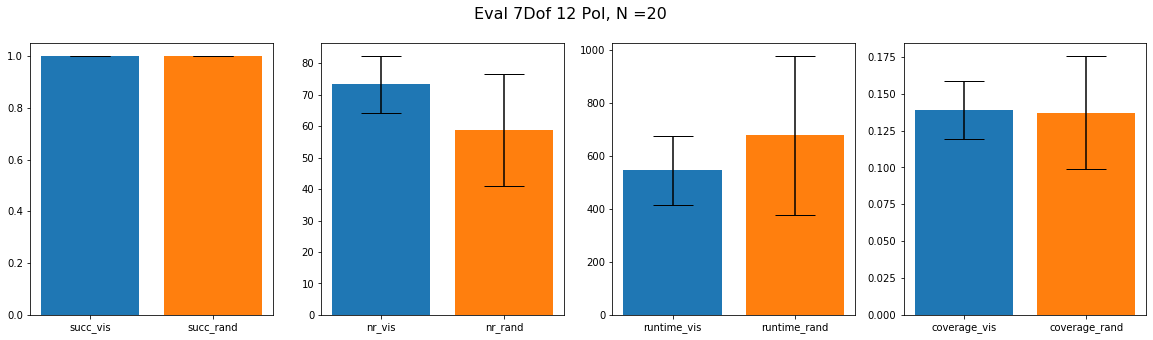

In [162]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = len(joint_keys), figsize = (20, 5))
for ax, key in zip(axs, joint_keys):
    nfields = 2
    xpos = np.arange(nfields)
    labels = [key+'_vis', key+'_rand']
    data_mean = [np.mean(np.array(vprmseed[key])*1.0), np.mean(np.array(randseed[key])*1.0)]
    data_std = [np.std(np.array(vprmseed[key])*1.0), np.std(np.array(randseed[key])*1.0)]
    ax.bar(xpos, data_mean, yerr = data_std,color=['#1f77b4','#ff7f0e'], ecolor='black', capsize=20)
    ax.set_xticks(xpos)
    ax.set_xticklabels(labels)
fig.suptitle('Eval 7Dof 12 PoI, N ='+str(len(vprmseed['seed'])), fontsize=16)

# Random Seeding

In [90]:
rs = RandSeeding(poi,
              alpha = 0.1,
              limits = limits_q,
              collision_handle = col_func_handle,
              iris_handle=partial(SNOPT_IRIS_Handle, regions = None),
              iris_handle_with_obstacles = SNOPT_IRIS_Handle,
              point_to_region_conversion = partial(Ratfk.ComputeTValue, q_star_val = np.zeros(7))
                 )
rs.set_init_regions()

[02:23:47] [RandSeeding] Expecting points of interest in q
[02:23:47] [RandSeeding] GuardInsertion attempts M: 44
[02:23:47] [RandSeeding] 0.9 probability that unseen region is less than 5.0 "%" of Cfree 


In [ ]:
rs.sample_regions_phase()

In [ ]:
rs.draw_connectivity_graph()

# RRT

In [ ]:
from rrt import RRT
RRT = RRT(start = poi[0],
          goal = poi[-1],
          limits = limits_q,
          col_func_handle=col_func_handle,
          max_extend_length=0.1,
          extend_steps=0.002,
          init_goal_sample_rate=0.1,
          goal_sample_rate_scaler=0.9,
          verbose = True, 
          plotcallback = None,
          sample_collision_free= False)

success, path = RRT.run(100000)